In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from glob import glob
import os
import json
from ecog_speech import datasets, feature_processing, experiments, utils
from tqdm.auto import tqdm

%matplotlib inline

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Load result JSON files into a list of objects

In [2]:
# Link a results dir in the project root
base_path = "../results/"

result_files = glob(os.path.join(base_path, '*.json'))

json_result_data = [json.load(open(f)) for f in tqdm(result_files)]

Parse into dataframe

In [3]:
results_df = pd.DataFrame(json_result_data).sort_values('f1', ascending=False)

results_df.columns

Index(['name', 'datetime', 'uid', 'batch_losses', 'num_trainable_params',
       'num_params', 'f1', 'accuracy', 'precision', 'recall', 'model_name',
       'dataset', 'dense_width', 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
       'n_cnn_filters', 'dropout', 'dropout_2d', 'batchnorm', 'roll_channels',
       'power_q', 'n_epochs', 'batch_size', 'device', 'save_model_path', 'tag',
       'result_dir', 'path'],
      dtype='object')

In [4]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_trainable_params,13.0,48566.538462,73752.303115,1515.000000,3311.000000,19109.000000,43083.000000,205323.000000
num_params,13.0,48566.538462,73752.303115,1515.000000,3311.000000,19109.000000,43083.000000,205323.000000
f1,13.0,0.831413,0.114058,0.568978,0.750024,0.916505,0.922560,0.929297
accuracy,13.0,0.839281,0.099373,0.658091,0.758786,0.912074,0.925479,0.931792
precision,13.0,0.863810,0.106037,0.724827,0.769568,0.872545,0.964595,0.974362
recall,13.0,0.810353,0.135766,0.451336,0.776773,0.866272,0.887765,0.965131
dense_width,6.0,128.000000,0.000000,128.000000,128.000000,128.000000,128.000000,128.000000
sn_n_bands,13.0,3.692308,1.377474,1.000000,3.000000,3.000000,5.000000,5.000000
sn_kernel_size,13.0,31.000000,0.000000,31.000000,31.000000,31.000000,31.000000,31.000000
sn_padding,13.0,13.000000,0.000000,13.000000,13.000000,13.000000,13.000000,13.000000


Config params are those parameters we want to split by if experiments were run with different values
- Use pandas to detect which config parameters were actually changed from the provided superset

In [5]:
perf_col = 'f1'

config_params = ['model_name', 'dataset', 'dense_width', 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
     'n_cnn_filters', 'dropout', 'dropout_2d', 'batchnorm', 'roll_channels', 'power_q', 'n_epochs']

In [6]:
nun_config_params = results_df[config_params].nunique()

config_cols = nun_config_params[nun_config_params > 1].index.tolist()

print(f"Changing Params: {', '.join(config_cols)}")

Changing Params: sn_n_bands, n_cnn_filters, dropout, roll_channels


***

Inspect and viz

In [10]:
res_perf_df = res_perf.reset_index()

In [11]:
res_perf_df

,sn_n_bands,n_cnn_filters,dropout,roll_channels,f1
0,1,16,0.50,False,0.926808
1,2,32,0.25,False,0.929297
2,3,4,0.00,False,0.917143
3,3,4,0.50,False,0.916505
4,3,8,0.00,True,0.568978
5,3,8,0.50,False,0.922560
6,3,8,0.75,False,0.919181
7,5,8,0.00,True,0.750024
8,5,16,0.00,False,0.924067
9,5,16,0.00,True,0.771659


In [7]:
grp = results_df.groupby(config_cols)[perf_col]
res_perf = grp.mean()
res_n = grp.size()

<AxesSubplot:xlabel='sn_n_bands', ylabel='n_cnn_filters-dropout-roll_channels'>

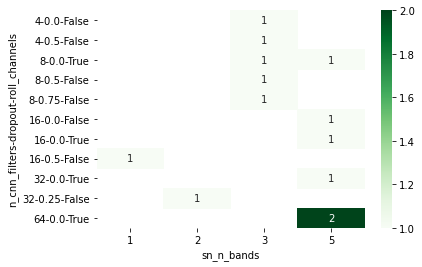

In [8]:
import seaborn as sns
sns.heatmap(res_n.unstack('sn_n_bands'), annot=True, cmap='Greens')

In [9]:
from IPython.display import display
def hplot(*args, **kwargs):
    #print(args)
    x = kwargs.pop('data')
    plt_df = x.groupby(list(args[:-1])).mean().reset_index().pivot(*args)
    #display(plt_df)
    ax = sns.heatmap(plt_df.T, 
                     annot=True, **kwargs)
    return ax

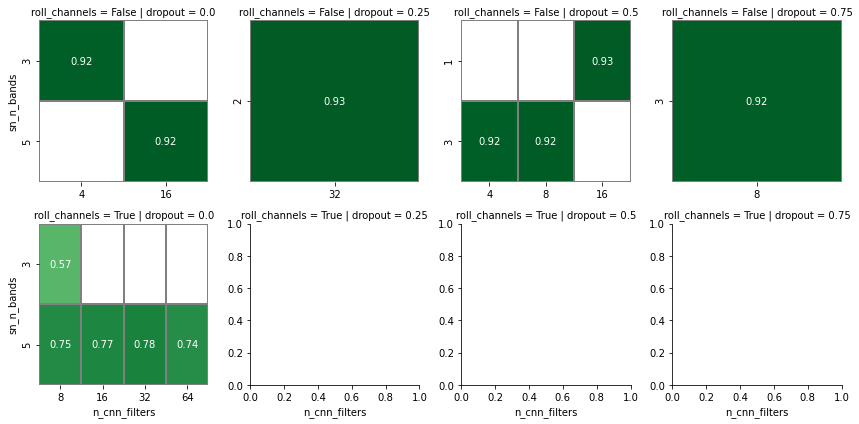

In [12]:
g = sns.FacetGrid(res_perf_df, row="roll_channels", col="dropout",
                  # Sharing axis doesn't seem to work so well with sparse results - axes names and ticks get weird
                  sharex=False, sharey=False)
g.map_dataframe(hplot,'n_cnn_filters', 'sn_n_bands', 'f1',
                cmap='Greens', vmax=1., vmin=0., cbar=False, linewidths=1, linecolor='grey')